In [14]:
%matplotlib inline
import numpy as np
import pandas as pd
import torch
from torch import nn
from d2l import torch as d2l
from typing import Tuple, List, Dict
from sklearn.model_selection import KFold
from matplotlib import pyplot as plt
from matplotlib.gridspec import GridSpec

# Kaggle比赛：预测房价

[比赛链接](https://www.kaggle.com/competitions/house-prices-advanced-regression-techniques/overview)

## 数据格式

In [41]:
train_data = pd.read_csv("./data/train.csv")
test_data = pd.read_csv("./data/test.csv")
train_data.shape, test_data.shape

((1460, 81), (1459, 80))

Id不属于特征，SalePrice是标签，因此包含79维特征，其中36维是数字类型的特征，43维是非数字类型的特征。

In [42]:
train_data.describe()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1460.000000,1460.000000,1201.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1452.000000,1460.000000,...,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,730.500000,56.897260,70.049958,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.685262,443.639726,...,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,180921.195890
std,421.610009,42.300571,24.284752,9981.264932,1.382997,1.112799,30.202904,20.645407,181.066207,456.098091,...,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,79442.502883
min,1.000000,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,365.750000,20.000000,59.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129975.000000
50%,730.500000,50.000000,69.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,...,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,1095.250000,70.000000,80.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,166.000000,712.250000,...,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,1460.000000,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,...,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


In [43]:
train_data.describe(exclude=[np.int64, np.float64])

,MSZoning,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,...,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,MiscFeature,SaleType,SaleCondition
count,1460,1460,91,1460,1460,1460,1460,1460,1460,1460,...,1379,1379,1379,1379,1460,7,281,54,1460,1460
unique,5,2,2,4,4,2,5,3,25,9,...,6,3,5,5,3,3,4,4,9,6
top,RL,Pave,Grvl,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,...,Attchd,Unf,TA,TA,Y,Gd,MnPrv,Shed,WD,Normal
freq,1151,1454,50,925,1311,1459,1052,1382,225,1260,...,870,605,1311,1326,1340,3,157,49,1267,1198


In [49]:
def read_data_from_csv() -> Tuple[pd.DataFrame, pd.DataFrame]:
    return pd.read_csv("./data/train.csv"), pd.read_csv("./data/test.csv")

## 数据预处理

### 数值型数据

对于数值类型的特征，需要将所有缺失值替换为平均值，另外为了避免出现过大的梯度，将特征使用同一尺度的缩放，使得特征在一个合理的范围内。

$$\begin{aligned}
    x' = \frac{x-\mu}{\sigma}
\end{aligned}$$

$$\begin{aligned}
    \mathrm{E}(x') 
        &= \mathrm{E}\left(\frac{x-\mu}{\sigma}\right) \\
        &= \frac{1}{n}\sum_{i=1}^{n}\frac{x_i-\mu}{\sigma} \\
        &= \frac{1}{n\sigma}\sum_{i=1}^n\left(x_i^2-2x_i\mu+\mu^2\right) \\
        &= 0
\end{aligned} \quad, 
\begin{aligned}
    \mathrm{Var}(x')
        &= \mathrm{E}\left[\left(\frac{x-\mu}{\sigma}\right)^2\right]-\mathrm{E}\left(\frac{x-\mu}{\sigma}\right)^2 \\
        &= \frac{1}{\sigma^2}\mathrm{E}\left(x^2-2x\mu+\mu^2\right) \\
        &= \frac{1}{\sigma^2}\mathrm{E}(x^2)-\mu^2 \\
        &= 1
\end{aligned}$$

In [33]:
def normalize_numeric_data_strategy1(features: pd.DataFrame) -> Tuple[pd.DataFrame, List[Dict]]:  #@save
    numric_features = features.dtypes[features.dtypes != 'object'].index
    means = {}
    stds = {}
    def op(x):
        mean, std = x.mean(), x.std()
        means[x.name] = mean
        stds[x.name] = std
        return (x - mean) / std
    features[numric_features] = features[numric_features].apply(op)
    features[numric_features] = features[numric_features].fillna(0)
    return features, [means, stds]

def recover_numeric_data_strategy1(features: pd.DataFrame, normalize: List[Dict]) -> pd.DataFrame:
    """nan的数据无法恢复，会置为均值
    """
    means, stds = normalize[0], normalize[1]
    numric_features = features.dtypes[features.dtypes != 'object'].index
    def op(x):
        mean, std = means[x.name], stds[x.name]
        return x * std + mean
    features[numric_features] = features[numric_features].apply(op)
    return features

df = pd.DataFrame([[1,2], [3,4], [np.nan,6]], columns=['A', 'B'])
df, d = normalize_numeric_data_strategy1(df)
print(df)
print(recover_numeric_data_strategy1(df, d))

          A    B
0 -0.707107 -1.0
1  0.707107  0.0
2  0.000000  1.0
     A    B
0  1.0  2.0
1  3.0  4.0
2  2.0  6.0


还有一种缩放策略是

$$\begin{aligned}
    x' &= \frac{x-\mu}
            {\max(\mathbf{x})-\min(\mathbf{x})}
\end{aligned}$$

$$\begin{aligned}
    \mathrm{E}(x') 
        &= \frac{1}{n}\sum_{i=1}^{n}x_i \\
        &= \frac{1}{n}\sum_{i=1}^{n}\frac{x_i-\mu}{\max(\mathbf{x})-\min(\mathbf{x})} \\
        &= \frac{1}{n(\max(\mathbf{x})-\min(\mathbf{x})}\left[\left(\sum_{i=1}^{n}x_i\right)-n\mu\right] \\
        &= 0
\end{aligned}\quad, 
\begin{aligned}
    \mathrm{Var}(x')
        &= \mathrm{E}\left[(x')^2\right]-\mathrm{E}\left(x'\right)^2 \\
        &= \mathrm{E}\left[\frac{\left(x-\mu\right)^2}{\left(\max(\mathbf{x})-\min(\mathbf{x})\right)^2}\right] \\
        &= \frac{1}{\left(\max(\mathbf{x})-\min(\mathbf{x})\right)^2}\mathrm{E}\left[(x-\mu)^2\right] \\
        &= \frac{1}{\left(\max(\mathbf{x})-\min(\mathbf{x})\right)^2}\mathrm{E}(x^2-2x\mu-\mu^2) \\
        &= \frac{1}{\left(\max(\mathbf{x})-\min(\mathbf{x})\right)^2}\left[\mathrm{E}(x^2)-\mu^2\right] \\
        &= \frac{\mathrm{Var}(x)}{\left(\max(\mathbf{x})-\min(\mathbf{x})\right)^2}
\end{aligned}$$

In [34]:
def normalize_numeric_data_strategy2(features: pd.DataFrame) -> Tuple[pd.DataFrame, List[Dict]]:  #@save
    numric_features = features.dtypes[features.dtypes != 'object'].index
    means = {}
    maxs = {}
    mins = {}
    def op(x):
        mean, max_, min_ = x.mean(), x.max(), x.min()
        means[x.name] = mean
        maxs[x.name] = max_
        mins[x.name] = min_
        return (x - mean) / (max_ - min_)
    features[numric_features] = features[numric_features].apply(op)
    features[numric_features] = features[numric_features].fillna(0)
    return features, [means, maxs, mins]

def recover_numeric_data_strategy2(features: pd.DataFrame, normalize: List[Dict]) -> pd.DataFrame:
    """nan的数据无法恢复，会置为均值
    """
    means, maxs, mins = normalize[0], normalize[1], normalize[2]
    numric_features = features.dtypes[features.dtypes != 'object'].index
    def op(x):
        mean, max_, min_ = means[x.name], maxs[x.name], mins[x.name]
        return x * (max_ - min_) + mean
    features[numric_features] = features[numric_features].apply(op)
    return features

df = pd.DataFrame([[1,2], [3,4], [np.nan,6]], columns=['A', 'B'])
df, d = normalize_numeric_data_strategy2(df)
print(df)
print(recover_numeric_data_strategy2(df, d))

     A    B
0 -0.5 -0.5
1  0.5  0.0
2  0.0  0.5
     A    B
0  1.0  2.0
1  3.0  4.0
2  2.0  6.0


### 非数值型数据
对于非数值型数据，一种是采用独热编码，另外一种是编码成整数，比如

特征$feat$包含$t$中可能的值，采用独热编码后，每个特征向量增加$t$个特征，即特征$feat$包含的$t$个可能的值，并且只有一个为1其余全0。

编码成整数后，这$t$个值映射到整数区间$[1, t]$。

In [35]:
def normalize_non_numerica_data_strategy1(features: pd.DataFrame) -> pd.DataFrame:
    return pd.get_dummies(features, dummy_na=True)

def normalize_non_numerica_data_strategy2(features: pd.DataFrame) -> pd.DataFrame:
    non_numerica_columns = list(features.dtypes[features.dtypes == 'object'].index)
    for col in non_numerica_columns:
        unique_values = pd.unique(features[col])
        for idx, v in enumerate(unique_values):
            features[col] = features[col].replace(v, idx + 1)
    return features

data = [{"A": 1, "B": "hello"}, {"A": 2, "B": "world"}, {"A": 3}]
df = pd.DataFrame(data)
normalize_non_numerica_data_strategy1(df), normalize_non_numerica_data_strategy2(df)

(   A  B_hello  B_world  B_nan
 0  1     True    False  False
 1  2    False     True  False
 2  3    False    False   True,
    A    B
 0  1  1.0
 1  2  2.0
 2  3  3.0)

## 模型定义

使用多层的线性回归模型来拟合。

In [73]:
class Net(nn.Module):
    def __init__(self, num_inputs, num_outputs, hidden_layers=None, 
                 dropouts=None, active_func=nn.ReLU()):
        if dropouts and len(dropouts) != len(hidden_layers):
            raise ValueError("length of dropouts not equal to number of hidden layer")
        super().__init__()
        print(f"init net: {num_inputs}, {num_outputs}, {hidden_layers}")
        self.active_func = active_func
        self.hidden_layer_modules = []
        self.dropout_modules = []
        self.num_inputs = num_inputs
        self.num_outputs = num_outputs
        if hidden_layers:
            for i in hidden_layers:
                self.hidden_layer_modules.append(nn.Linear(num_inputs, i))
                num_inputs = i
        if dropouts:
            for p in dropouts:
                self.dropout_modules.append(nn.Dropout(p))

        self.output_layer = nn.Linear(num_inputs, num_outputs)

    def forward(self, X):
        h = X.reshape((-1, self.num_inputs))
        for i, module in enumerate(self.hidden_layer_modules):
            h = module(h)
            if self.dropout_modules and self.training:
                h = self.dropout_modules[i](h)
            self.active_func(h)
        out = self.output_layer(h)
        return out

## 训练

In [37]:
def log_rmse(net, features, labels, loss, recover_label_ctx, recover_fn):
    # 为了在取对数时进一步稳定该值，将小于1的值设置为1
    clipped_preds = net(features)
    clipped_preds = torch.tensor(recover_fn(pd.DataFrame(clipped_preds, columns=["SalePrice"]), recover_label_ctx).values, dtype=torch.float32)
    clipped_preds = torch.clamp(clipped_preds, 1, float('inf'))
    labels = torch.tensor(recover_fn(pd.DataFrame(labels, columns=["SalePrice"]), recover_label_ctx).values, dtype=torch.float32)
    # print(torch.unique(torch.log(clipped_preds)==float('nan')))
    # print(torch.log(clipped_preds),torch.log(labels))
    rmse = torch.sqrt(loss(torch.log(clipped_preds),
                           torch.log(labels)))
    return rmse.item()

def train(net, train_features, train_labels, test_features, test_labels,
          num_epochs, learning_rate, weight_decay, batch_size, loss, 
          recover_label_ctx, recover_fn, need_plot=True, animator=None):
    if isinstance(net, nn.Module):
        net.train()
    train_ls, test_ls = [], []
    train_iter = d2l.load_array((train_features, train_labels), batch_size)
    optimizer = torch.optim.Adam(net.parameters(),
                                 lr = learning_rate,
                                 weight_decay = weight_decay)
    if need_plot:
        if not animator:
            animator = d2l.Animator(xlabel="epoch", ylabel="loss", 
                                    xlim=[1, num_epochs+1], yscale="log", 
                                    legend=["loss", "rmse loss"], figsize=(6, 4))
    for epoch in range(num_epochs):
        for X, y in train_iter:
            optimizer.zero_grad()
            l = loss(net(X), y)
            l.backward()
            optimizer.step()
        with torch.no_grad():
            rmse_loss = log_rmse(net, train_features, train_labels, loss, recover_label_ctx, recover_fn)
            l = loss(net(train_features), train_labels)
            # print(rmse_loss, l)
            train_ls.append(rmse_loss)
        if need_plot:
            animator.add(epoch+1, [l.item(), rmse_loss])
        if test_labels is not None:
            with torch.no_grad():
                test_ls.append(log_rmse(net, test_features, test_labels, loss, recover_label_ctx, recover_fn))
    return train_ls, test_ls

### K折交叉验证

$$\begin{array}{c|c}
    \hline
    hidden\ layer \ number& \quad 隐藏层数量 \quad \\
    hidden\ layer \ uniq \ number& \quad 隐藏层配置 \quad \\
    dropout& \quad 暂退法配置 \quad \\
    learning \ rate& \quad 学习率 \quad \\
    epoch\ number& \quad 训练周期 \quad \\
    weight\ decay& \quad 罚项 \quad \\
    batch\ size& \quad 小批量配置 \\
    \hline
\end{array}$$

总共有七个超参数，使用K折交叉验证能够有助于模型选择和超参数调整。

In [54]:
def k_fold_train(get_net, X_train, y_train,
          num_epochs, learning_rate, weight_decay, batch_size, loss, 
          recover_label_ctx, recover_fn, k=5):
    kf = KFold(k, shuffle=True)
    ncols = 3
    nrows = (k + ncols) // ncols 
    fig = plt.figure(layout="constrained", figsize=(6*ncols, 4*nrows))
    gs = GridSpec(nrows, ncols, fig)
    i, j = 0, 0 
    train_loss_sum, valid_loss_sum = 0, 0
    for t, (train_index, valid_index) in enumerate(kf.split(X_train)):
        train_features, valid_features = X_train[train_index], X_train[valid_index]
        train_labels, valid_labels = y_train[train_index], y_train[valid_index]
        ax = fig.add_subplot(gs[i, j])
        j += 1
        if j == ncols:
            i += 1
            j = 0
        ax.set_xlim(1, num_epochs)
        ax.set_xlabel("epoch"), ax.set_ylabel("rmse loss")
        ax.set_title(r"k={}".format(t+1))
        train_loss, valid_loss = train(get_net(), train_features, train_labels, valid_features, valid_labels,
                                       num_epochs, learning_rate, weight_decay, batch_size, loss,
                                       recover_label_ctx, recover_fn, need_plot=False)
        train_loss_sum += train_loss[-1]
        valid_loss_sum += valid_loss[-1]
        for label, curr_loss in zip(("train", "valid"), (train_loss, valid_loss)):
            ax.plot(list(range(1, num_epochs+1)), curr_loss, label=label)
        ax.legend() 
    return train_loss_sum / k, valid_loss_sum / k

### 选择数据预处理策略

上面定义了两种数据预处理的策略，通过最基本的线性模型来确定选择什么数据预处理策略

第一种策略完胜！

init net: 330, 1, None
init net: 330, 1, None
init net: 330, 1, None
init net: 330, 1, None
init net: 330, 1, None
normalize data by strategy1, train_loss:0.11543853729963302, valid_loss:0.17141676247119902


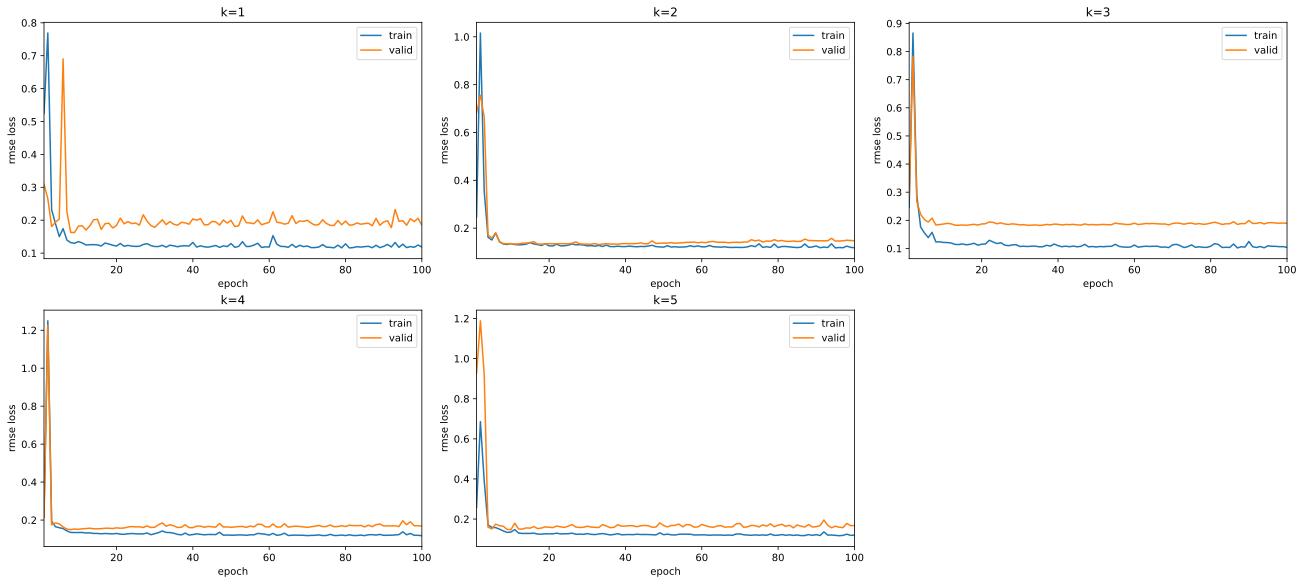

In [70]:
train_data, test_data = read_data_from_csv()
n_train = train_data.shape[0]
all_features = pd.concat((train_data.iloc[:, 1:-1], test_data.iloc[:, 1:]))
normalize_all_features, _ = normalize_numeric_data_strategy1(all_features)
normalize_all_features = normalize_non_numerica_data_strategy1(normalize_all_features)
train_labels = pd.DataFrame(train_data, columns=["SalePrice"])
normalize_train_labels, recover_labels_ctx = normalize_numeric_data_strategy1(train_labels)
loss = nn.MSELoss()
num_epochs = 100
batch_size = 256
lr = 0.01
X = torch.tensor(normalize_all_features[:n_train].values.astype(float), dtype=torch.float32)
y = torch.tensor(normalize_train_labels.values.astype(float), dtype=torch.float32)
def get_net():
    return Net(X.shape[-1], 1)

train_loss, valid_loss = k_fold_train(get_net, X, y, num_epochs, lr, 0, batch_size, loss,
                                      recover_labels_ctx, recover_numeric_data_strategy1)
print(f"normalize data by strategy1, train_loss:{train_loss}, valid_loss:{valid_loss}")
plt.show()

init net: 79, 1, None
init net: 79, 1, None
init net: 79, 1, None
init net: 79, 1, None
init net: 79, 1, None
normalize data by strategy2, train_loss:0.2303590089082718, valid_loss:0.3631044000387192


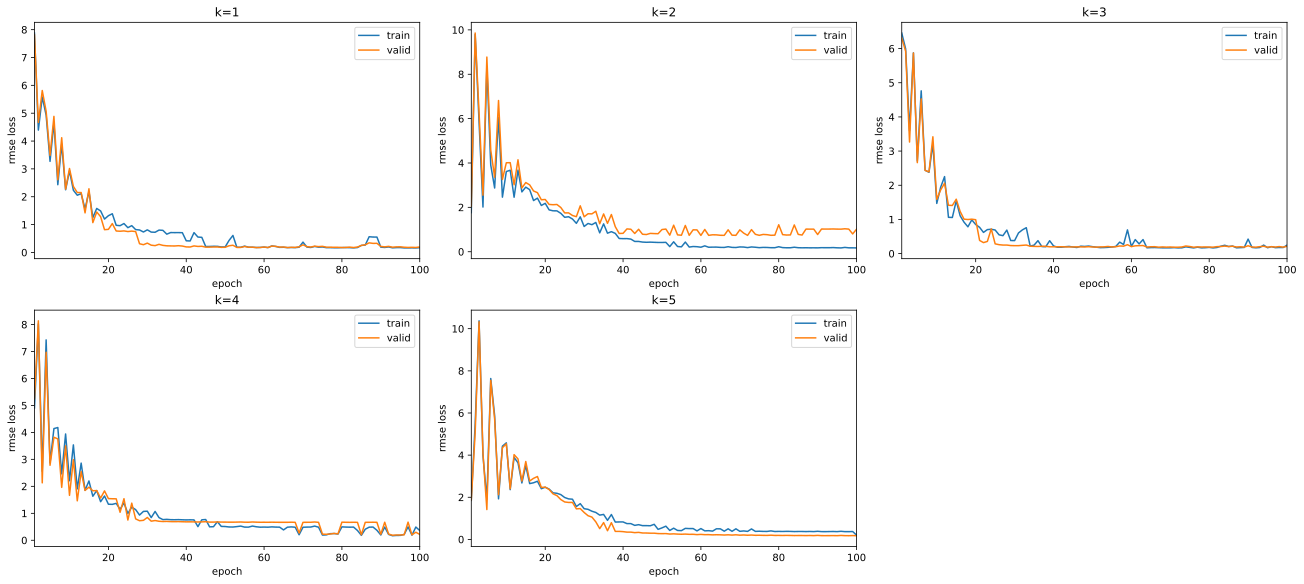

In [71]:
train_data, test_data = read_data_from_csv()
n_train = train_data.shape[0]
all_features = pd.concat((train_data.iloc[:, 1:-1], test_data.iloc[:, 1:]))
normalize_all_features, _ = normalize_numeric_data_strategy2(all_features)
normalize_all_features = normalize_non_numerica_data_strategy2(normalize_all_features)
train_labels = pd.DataFrame(train_data, columns=["SalePrice"])
normalize_train_labels, recover_labels_ctx = normalize_numeric_data_strategy2(train_labels)
X = torch.tensor(normalize_all_features[:n_train].values.astype(float), dtype=torch.float32)
y = torch.tensor(normalize_train_labels.values.astype(float), dtype=torch.float32)
def get_net():
    return Net(normalize_all_features.shape[-1], 1)
train_loss, valid_loss = k_fold_train(get_net, X, y, num_epochs, lr, 0, batch_size, loss, recover_labels_ctx,
                                   recover_numeric_data_strategy2)
print(f"normalize data by strategy2, train_loss:{train_loss}, valid_loss:{valid_loss}")
plt.show()

### 使用更复杂的模型

|hidden layer| train loss| valid loss|
|:-:|:-:|:-:|
|[256]|0.137|0.167|
|[256,64]|0.246|0.278|
|[500,1000,200]|0.148|0.160|
|[500,1000,200,64]|0.329|0.218|

init net: 330, 1, [500, 1000, 200]
init net: 330, 1, [500, 1000, 200]
init net: 330, 1, [500, 1000, 200]
init net: 330, 1, [500, 1000, 200]
init net: 330, 1, [500, 1000, 200]
train_loss:0.14252308309078215, valid_loss:0.1636190503835678


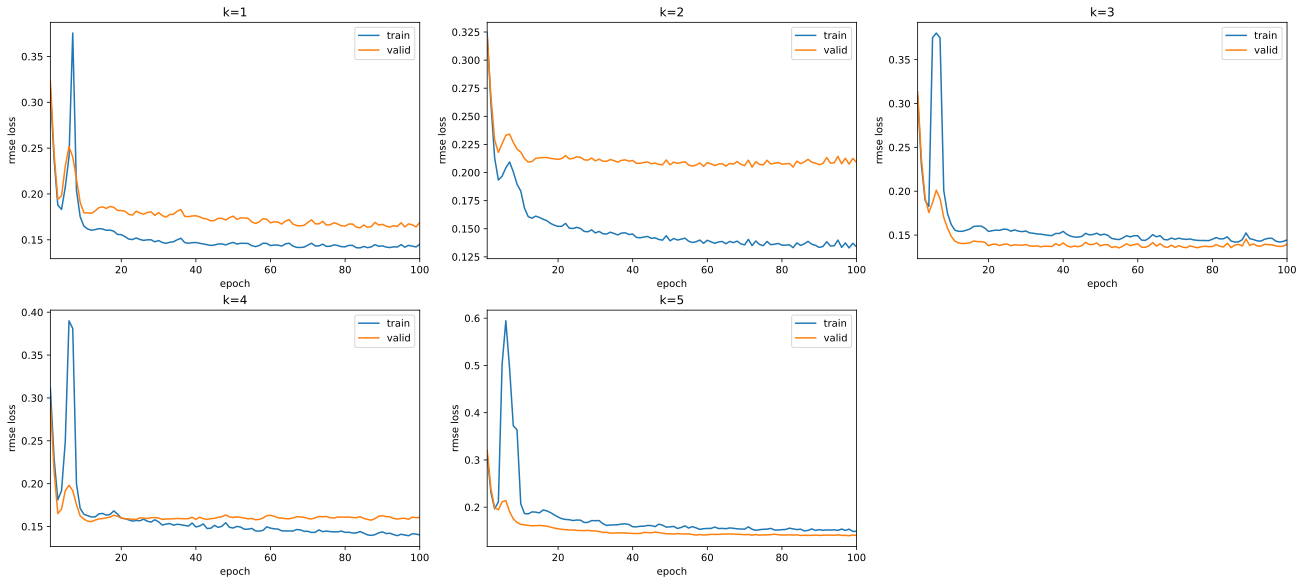

In [84]:
train_data, test_data = read_data_from_csv()
n_train = train_data.shape[0]
all_features = pd.concat((train_data.iloc[:, 1:-1], test_data.iloc[:, 1:]))
normalize_all_features, _ = normalize_numeric_data_strategy1(all_features)
normalize_all_features = normalize_non_numerica_data_strategy1(normalize_all_features)
train_labels = pd.DataFrame(train_data, columns=["SalePrice"])
normalize_train_labels, recover_labels_ctx = normalize_numeric_data_strategy1(train_labels)
loss = nn.MSELoss()
num_epochs = 100
batch_size = 256
lr = 0.01
X = torch.tensor(normalize_all_features[:n_train].values.astype(float), dtype=torch.float32)
y = torch.tensor(normalize_train_labels.values.astype(float), dtype=torch.float32)
def get_net():
    hidden_layers = [500, 1000, 200]
    return Net(X.shape[-1], 1, hidden_layers)
train_loss, valid_loss = k_fold_train(get_net, X, y, num_epochs, lr, 0, batch_size, loss, recover_labels_ctx,
                                   recover_numeric_data_strategy1)
print(f"train_loss:{train_loss}, valid_loss:{valid_loss}")
plt.show()

使用如下超参数进行训练

|超参数|值|
|:-:|:-:|
|num_epochs| 100|
|learning rate|0.01|
|weight_decay|0|
|batch size| 256|
|hidden layers|[500,1000,200]|
|dropouts|None|

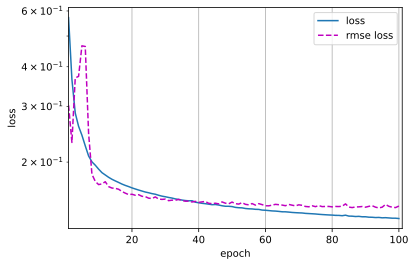

In [87]:
train_data, test_data = read_data_from_csv()
n_train = train_data.shape[0]
all_features = pd.concat((train_data.iloc[:, 1:-1], test_data.iloc[:, 1:]))
normalize_all_features, _ = normalize_numeric_data_strategy1(all_features)
normalize_all_features = normalize_non_numerica_data_strategy1(normalize_all_features)
train_labels = pd.DataFrame(train_data, columns=["SalePrice"])
normalize_train_labels, recover_labels_ctx = normalize_numeric_data_strategy1(train_labels)
loss = nn.MSELoss()
num_epochs = 100
batch_size = 256
lr = 0.01
X = torch.tensor(normalize_all_features[:n_train].values.astype(float), dtype=torch.float32)
y = torch.tensor(normalize_train_labels.values.astype(float), dtype=torch.float32)
def get_net():
    hidden_layers = [500, 1000, 200]
    return Net(X.shape[-1], 1, hidden_layers)
net = get_net()
_, _ = train(net, X, y, None, None, num_epochs, lr, 0, batch_size, loss,
      recover_labels_ctx, recover_numeric_data_strategy1)

## 预测

In [93]:
test_X = torch.tensor(normalize_all_features[n_train:].values.astype(float), dtype=torch.float32)
test_pred = net(test_X).detach().numpy()
test_pred_df = pd.DataFrame(test_pred, columns=["SalePrice"])
test_pred_df = recover_numeric_data_strategy1(test_pred_df, recover_labels_ctx)
test_pred_df = pd.concat([test_data["Id"], test_pred_df["SalePrice"]], axis=1)
test_pred_df.to_csv("./data/submission.csv", index=False)